# Lecture 14 – Data 100, Spring 2024

Data 100, Spring 2024

[Acknowledgments Page](https://ds100.org/sp24/acks/)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
import plotly.graph_objects as go
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=UserWarning)
np.random.seed(42)

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

## Feature Engineering

Feature engineering is the process of applying **feature functions** to generate new features for use in modeling. In this lecture, we will discuss:
* One-hot encoding
* Polynomial features

To do so, we'll work with our familiar `tips` dataset.

In [2]:
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### One-Hot Encoding

One-hot encoding is a feature engineering technique to generate numeric feature from categorical data. For example, we can use one-hot encoding to incorporate the day of the week as an input into a regression model.

![](ohe.png)

Suppose we want to use a design matrix of three features – the `total_bill`, `size`, and `day` – to predict the tip.

In [3]:
X_raw = tips[["total_bill", "size", "day"]]
y = tips["tip"]

In [8]:
#teste RLS
from sklearn.linear_model import LinearRegression
model_test= LinearRegression()
model_test.fit(X_raw, y)
model_test.coef_

ValueError: could not convert string to float: 'Sun'

Because `day` is non-numeric, we will apply one-hot encoding before fitting a model.

The `OneHotEncoder` class of `sklearn` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder.get_feature_names_out)) offers a quick way to perform one-hot encoding. You will explore its use in detail in Lab 7. For now, recognize that we follow a very similar workflow to when we were working with the `LinearRegression` class: we initialize a `OneHotEncoder` object, fit it to our data, then use `.transform` to apply the fitted encoder.

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Initialize a OneHotEncoder object
ohe = OneHotEncoder()

# Fit the encoder
ohe.fit(tips[["day"]])

# Use the encoder to transform the raw "day" feature
encoded_day = ohe.transform(tips[["day"]]).toarray()
encoded_day_df = pd.DataFrame(encoded_day, columns=ohe.get_feature_names_out())

encoded_day_df.head()

,day_Fri,day_Sat,day_Sun,day_Thur
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


The `OneHotEncoder` has converted the categorical `day` feature into four numeric features! Recall that the `tips` dataset only included data for Thursday through Sunday, which is why only four days of the week appear.

Let's join this one-hot encoding to the original data to form our featurized design matrix. We drop the original `day` column so our design matrix only includes numeric values.

In [10]:
X = X_raw.join(encoded_day_df).drop(columns="day")

X.head()

,total_bill,size,day_Fri,day_Sat,day_Sun,day_Thur
0,16.99,2,0.0,0.0,1.0,0.0
1,10.34,3,0.0,0.0,1.0,0.0
2,21.01,3,0.0,0.0,1.0,0.0
3,23.68,2,0.0,0.0,1.0,0.0
4,24.59,4,0.0,0.0,1.0,0.0


Now, we can use `sklearn`'s `LinearRegression` class to fit a model to this design matrix.

In [11]:
from sklearn.linear_model import LinearRegression
ohe_model = LinearRegression(fit_intercept=False) # Tell sklearn to not add an additional bias column. Why?
ohe_model.fit(X, y)

pd.DataFrame({"Feature":X.columns, "Model Coefficient":ohe_model.coef_}).set_index("Feature")

,Model Coefficient
Feature,
total_bill,0.092994
size,0.187132
day_Fri,0.745787
day_Sat,0.621129
day_Sun,0.732289
day_Thur,0.668294


### Bonus: Advanced Feature Engineering Pipelines in Scikit Learn
You can use the scikit learn `Pipeline` class to define sophisticated feature engineering pipelines that combine different transformations that are all fit at once.

A pipeline is a sequence of transformations and models that are composed to form a new model. It is implemented as a list of  ("name", model/transformation) tuples.  Here we have a feature engineering stage followed by a linear model. The feature engineering stage uses a `ColumnTransformer` that applies named transformations to selected columns.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

pl = Pipeline([
    ("Feature Engineering",
     ColumnTransformer(
         [("OHE", OneHotEncoder(), ["day"]),
         ("Polynomial", PolynomialFeatures(4), ['total_bill'])],
        remainder="passthrough")),
    ("Linear Model", LinearRegression()) # Linear Model
])
pl

Pipeline(steps=[('Feature Engineering',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE', OneHotEncoder(),
                                                  ['day']),
                                                 ('Polynomial',
                                                  PolynomialFeatures(degree=4),
                                                  ['total_bill'])])),
                ('Linear Model', LinearRegression())])

In [13]:
pl.fit(X_raw, y)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('Feature Engineering',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE', OneHotEncoder(),
                                                  ['day']),
                                                 ('Polynomial',
                                                  PolynomialFeatures(degree=4),
                                                  ['total_bill'])])),
                ('Linear Model', LinearRegression())])

All the features:

In [14]:
pl['Feature Engineering'].get_feature_names_out()

array(['OHE__day_Fri', 'OHE__day_Sat', 'OHE__day_Sun', 'OHE__day_Thur',
       'Polynomial__1', 'Polynomial__total_bill',
       'Polynomial__total_bill^2', 'Polynomial__total_bill^3',
       'Polynomial__total_bill^4', 'remainder__size'], dtype=object)

In [15]:
tips["predicted"] = pl.predict(X_raw)
tips

,total_bill,tip,sex,smoker,day,time,size,predicted
0,16.99,1.01,Female,No,Sun,Dinner,2,2.780923
1,10.34,1.66,Male,No,Sun,Dinner,3,2.113310
2,21.01,3.50,Male,No,Sun,Dinner,3,3.492110
3,23.68,3.31,Male,No,Sun,Dinner,2,3.536788
4,24.59,3.61,Female,No,Sun,Dinner,4,3.998847
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,3.775789
240,27.18,2.00,Female,Yes,Sat,Dinner,2,3.539331
241,22.67,2.00,Male,Yes,Sat,Dinner,2,3.277145
242,17.82,1.75,Male,No,Sat,Dinner,2,2.718728


<br/><br/><br/>
**Return to Lecture**

<br/><br/><br/>

### Polynomial Features

Consider the `vehicles` dataset, which includes information about cars.

In [ ]:
vehicles = sns.load_dataset("mpg").dropna().rename(columns = {"horsepower": "hp"}).sort_values("hp")
vehicles.head()

,mpg,cylinders,displacement,hp,weight,acceleration,model_year,origin,name
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel)
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel)
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel


Suppose we want to use the `hp` (horsepower) of a car to predict its `mpg` (gas mileage in miles per gallon). If we visualize the relationship between these two variables, we see a non-linear curvature. Fitting a linear model to these variables results in a high (poor) value of RMSE.

$$\hat{y} = \theta_0 + \theta_1 (\text{hp})$$

In [ ]:
X = vehicles[["hp"]]
y = vehicles["mpg"]

hp_model = LinearRegression()
hp_model.fit(X, y)
hp_model_predictions = hp_model.predict(X)

print(f"MSE of model with (hp) feature: {np.mean((y-hp_model_predictions)**2)}")

fig = px.scatter(vehicles, x="hp", y="mpg", width=800, height=600)
fig.add_trace(go.Scatter(x=vehicles["hp"], y=hp_model_predictions,
                         mode="lines", name="Linear Prediction"))
# sns.scatterplot(data=vehicles, x="hp", y="mpg")
# plt.plot(vehicles["hp"], hp_model_predictions, c="tab:red");



MSE of model with (hp) feature: 23.943662938603108


To capture the non-linear relationship between the variables, we can introduce a non-linear feature: `hp` squared. Our new model is:

$$\hat{y} = \theta_0 + \theta_1 (\text{hp}) + \theta_2 (\text{hp}^2)$$

In [ ]:
X = vehicles[["hp"]]
X.loc[:, "hp^2"] = vehicles["hp"]**2

hp2_model = LinearRegression()
hp2_model.fit(X, y)
hp2_model_predictions = hp2_model.predict(X)


print(f"MSE of model with (hp^2) feature: {np.mean((y-hp2_model_predictions)**2)}")

fig = px.scatter(vehicles, x="hp", y="mpg", width=800, height=600)
fig.add_trace(go.Scatter(x=vehicles["hp"], y=hp2_model_predictions,
                         mode="lines", name="Quadratic Prediction"))
# sns.scatterplot(data=vehicles, x="hp", y="mpg")
# plt.plot(vehicles["hp"], hp2_model_predictions, c="tab:red");


MSE of model with (hp^2) feature: 18.98476890761722


What if we take things further and add even *more* polynomial features?

The cell below fits models of increasing complexity and computes their MSEs.

In [ ]:
def mse(predictions, observations):
    return np.mean((observations - predictions)**2)

# Add hp^3 and hp^4 as features to the data
X["hp^3"] = vehicles["hp"]**3
X["hp^4"] = vehicles["hp"]**4

# Fit a model with order 3
hp3_model = LinearRegression()
hp3_model.fit(X[["hp", "hp^2", "hp^3"]], vehicles["mpg"])
hp3_model_predictions = hp3_model.predict(X[["hp", "hp^2", "hp^3"]])

# Fit a model with order 4
hp4_model = LinearRegression()
hp4_model.fit(X[["hp", "hp^2", "hp^3", "hp^4"]], vehicles["mpg"])
hp4_model_predictions = hp4_model.predict(X[["hp", "hp^2", "hp^3", "hp^4"]])

In [ ]:
fig = px.scatter(vehicles, x="hp", y="mpg", width=800, height=600)
fig.add_trace(go.Scatter(
    x=vehicles["hp"], y=hp_model_predictions, mode="lines",
    name=f"HP MSE={np.round(mse(vehicles['mpg'], hp_model_predictions),3)}"))
fig.add_trace(go.Scatter(
    x=vehicles["hp"], y=hp2_model_predictions, mode="lines",
    name=f"HP^2 MSE={np.round(mse(vehicles['mpg'], hp2_model_predictions),3)}"))
fig.add_trace(go.Scatter(
    x=vehicles["hp"], y=hp3_model_predictions, mode="lines",
    name=f"HP^3 MSE={np.round(mse(vehicles['mpg'], hp3_model_predictions),3)}"))
fig.add_trace(go.Scatter(
    x=vehicles["hp"], y=hp4_model_predictions, mode="lines",
    name=f"HP^4 MSE={np.round(mse(vehicles['mpg'], hp4_model_predictions),3)}"))

Visualizing differently:

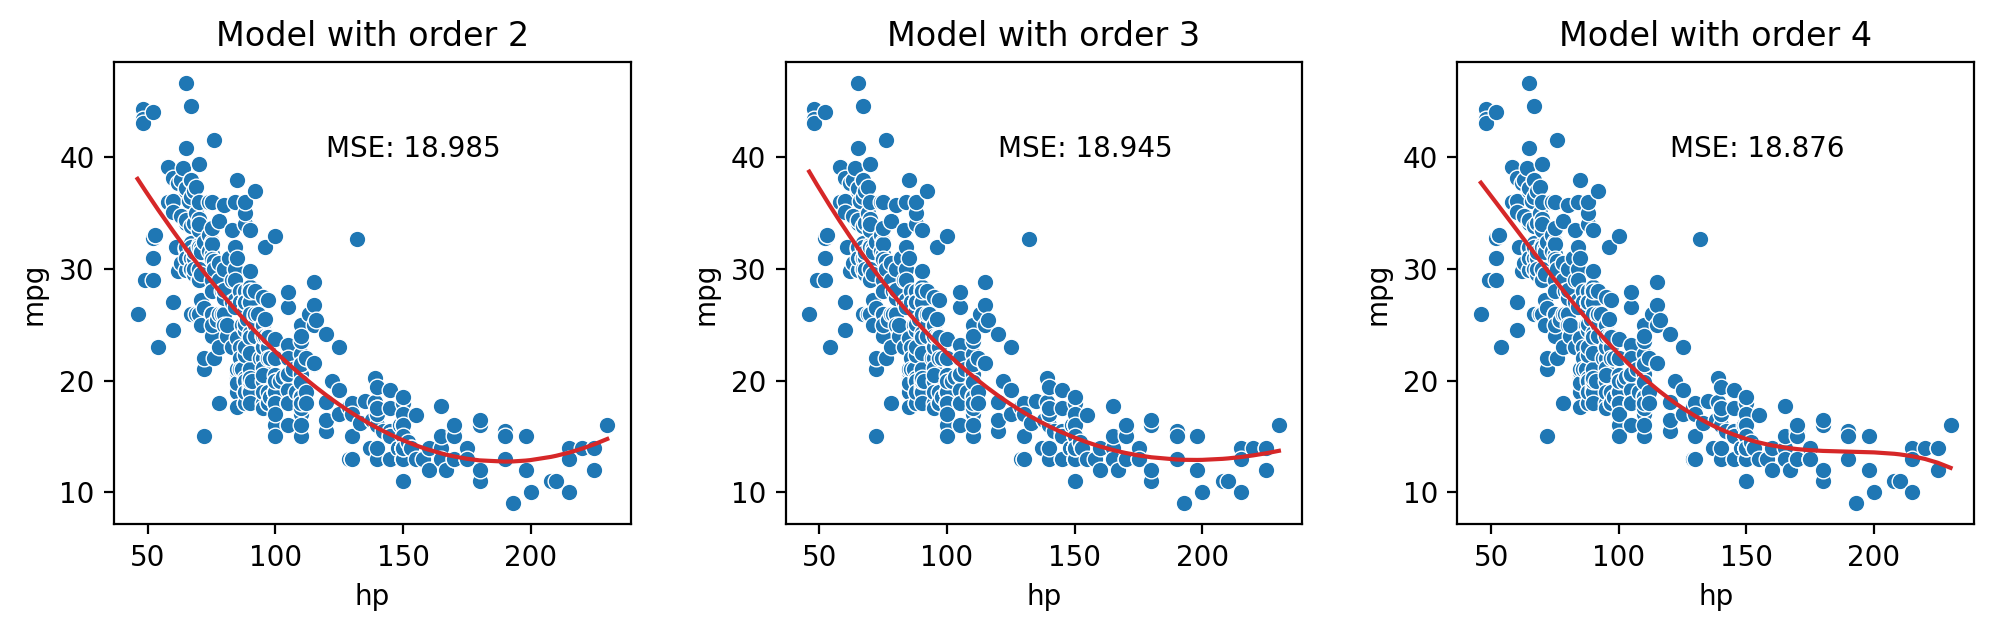

In [ ]:
# Plot the models' predictions
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

predictions_dict = {0:hp2_model_predictions, 1:hp3_model_predictions, 2:hp4_model_predictions}

for i in predictions_dict:
    ax[i].scatter(vehicles["hp"], vehicles["mpg"], edgecolor="white", lw=0.5)
    ax[i].plot(vehicles["hp"], predictions_dict[i], "tab:red")
    ax[i].set_title(f"Model with order {i+2}")
    ax[i].set_xlabel("hp")
    ax[i].set_ylabel("mpg")
    ax[i].annotate(f"MSE: {np.round(mse(vehicles['mpg'], predictions_dict[i]), 3)}", (120, 40))

plt.subplots_adjust(wspace=0.3);

## Complexity and Overfitting

What we saw above was the phenomenon of **model complexity** – as we add additional features to the design matrix, the model becomes increasingly *complex*. Models with higher complexity have lower values of training error. Intuitively, this makes sense: with more features at its disposal, the model can match the observations in the trainining data more and more closely.

We can run an experiment to see this in action. In the cell below, we fit many models of progressively higher complexity, then plot the MSE of predictions on the training set. The code used (specifically, the `Pipeline` and `PolynomialFeatures` functions of `sklearn`) is out of scope.

The **order** of a polynomial model is the highest power of any term in the model. An order 0 model takes the form $\hat{y} = \theta_0$, while an order 4 model takes the form $\hat{y} = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 + \theta_4 x^4$.

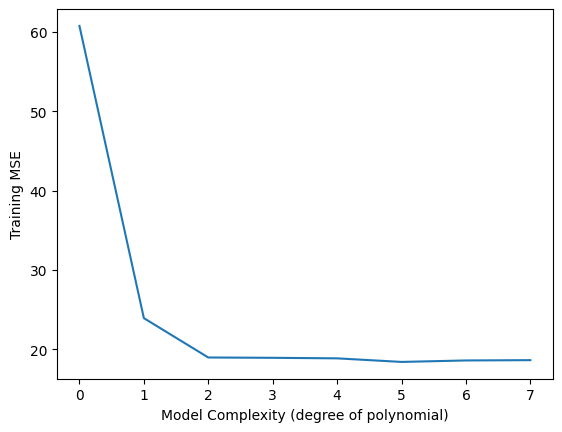

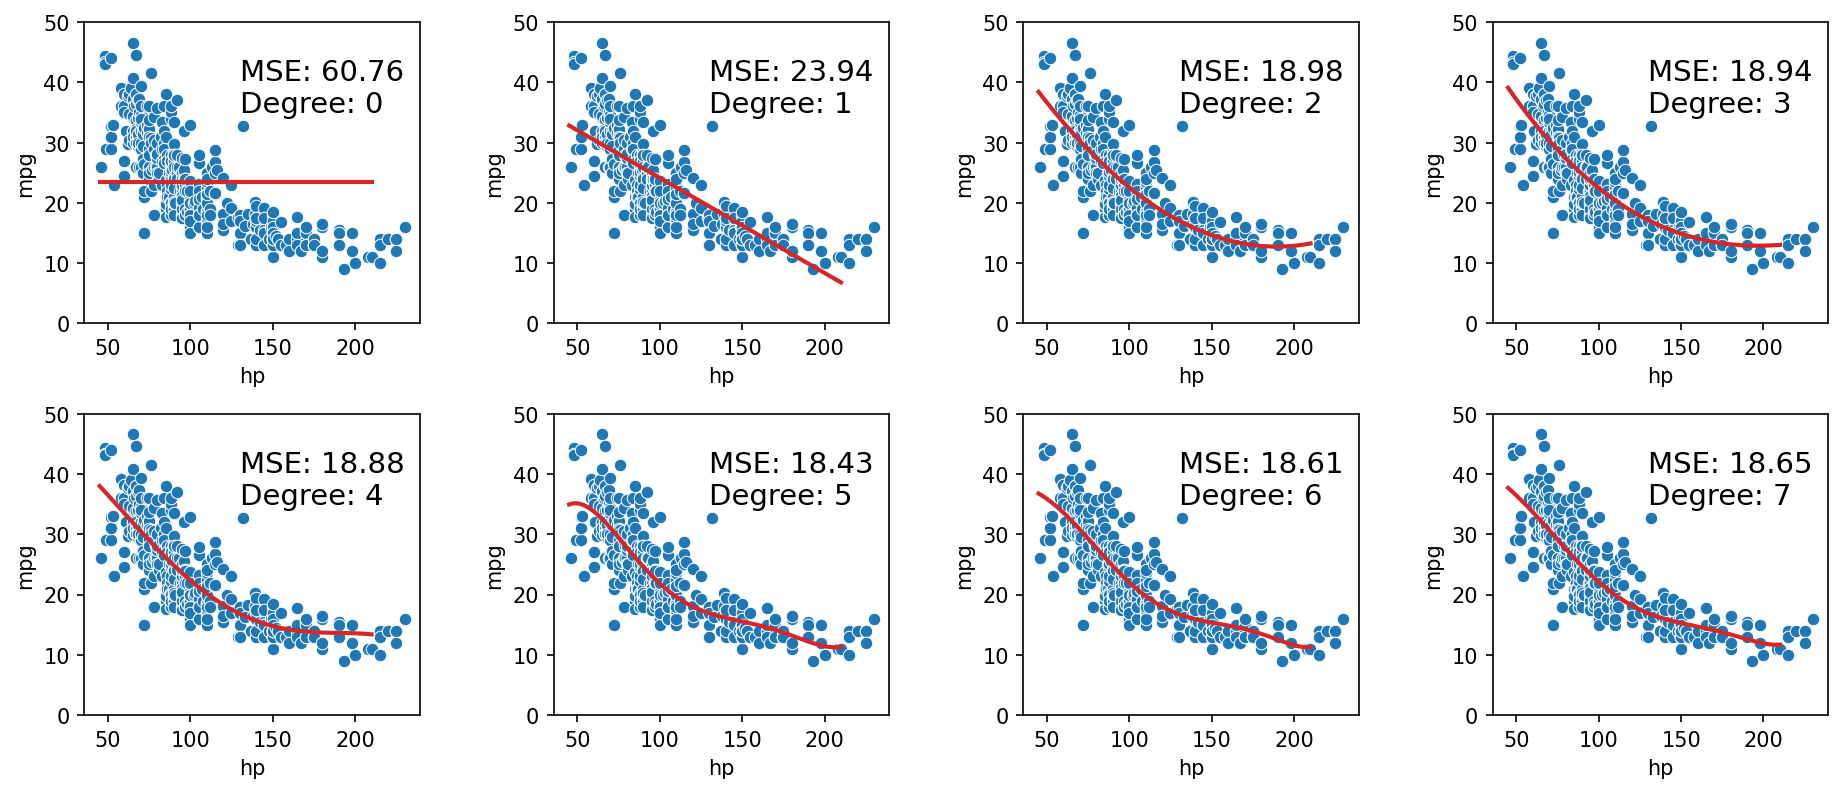

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_model_dataset(degree, dataset):
    pipelined_model = Pipeline([
            ('polynomial_transformation', PolynomialFeatures(degree)),
            ('linear_regression', LinearRegression())
        ])

    pipelined_model.fit(dataset[["hp"]], dataset["mpg"])
    return mse(dataset['mpg'], pipelined_model.predict(dataset[["hp"]]))

errors = [fit_model_dataset(degree, vehicles) for degree in range(0, 8)]
MSEs_and_k = pd.DataFrame({"k": range(0, 8), "MSE": errors})

plt.plot(range(0, 8), errors)
plt.xlabel("Model Complexity (degree of polynomial)")
plt.ylabel("Training MSE");

def plot_degree_k_model(k, MSEs_and_k, axs):
    pipelined_model = Pipeline([
        ('poly_transform', PolynomialFeatures(degree = k)),
        ('regression', LinearRegression(fit_intercept = True))
    ])
    pipelined_model.fit(vehicles[["hp"]], vehicles["mpg"])

    row = k // 4
    col = k % 4
    ax = axs[row, col]

    sns.scatterplot(data=vehicles, x='hp', y='mpg', ax=ax)

    x_range = np.linspace(45, 210, 100).reshape(-1, 1)
    ax.plot(x_range, pipelined_model.predict(pd.DataFrame(x_range, columns=['hp'])), c='tab:red', linewidth=2)

    ax.set_ylim((0, 50))
    mse_str = f"MSE: {MSEs_and_k.loc[k, 'MSE']:.4}\nDegree: {k}"
    ax.text(130, 35, mse_str, dict(size=14))

fig = plt.figure(figsize=(15, 6), dpi=150)
axs = fig.subplots(nrows=2, ncols=4)

for k in range(8):
    plot_degree_k_model(k, MSEs_and_k, axs)
fig.subplots_adjust(wspace=0.4, hspace=0.3)

As the model increases in polynomial degree (that is, it increases in complexity), the training MSE decreases, plateauing at roughly ~18.

In fact, it is a mathematical fact that if we create a polynomial model with degree $n-1$, we can *perfectly* model a set of $n$ points. For example, a set of 5 points can be perfectly modeled by a degree 4 model.

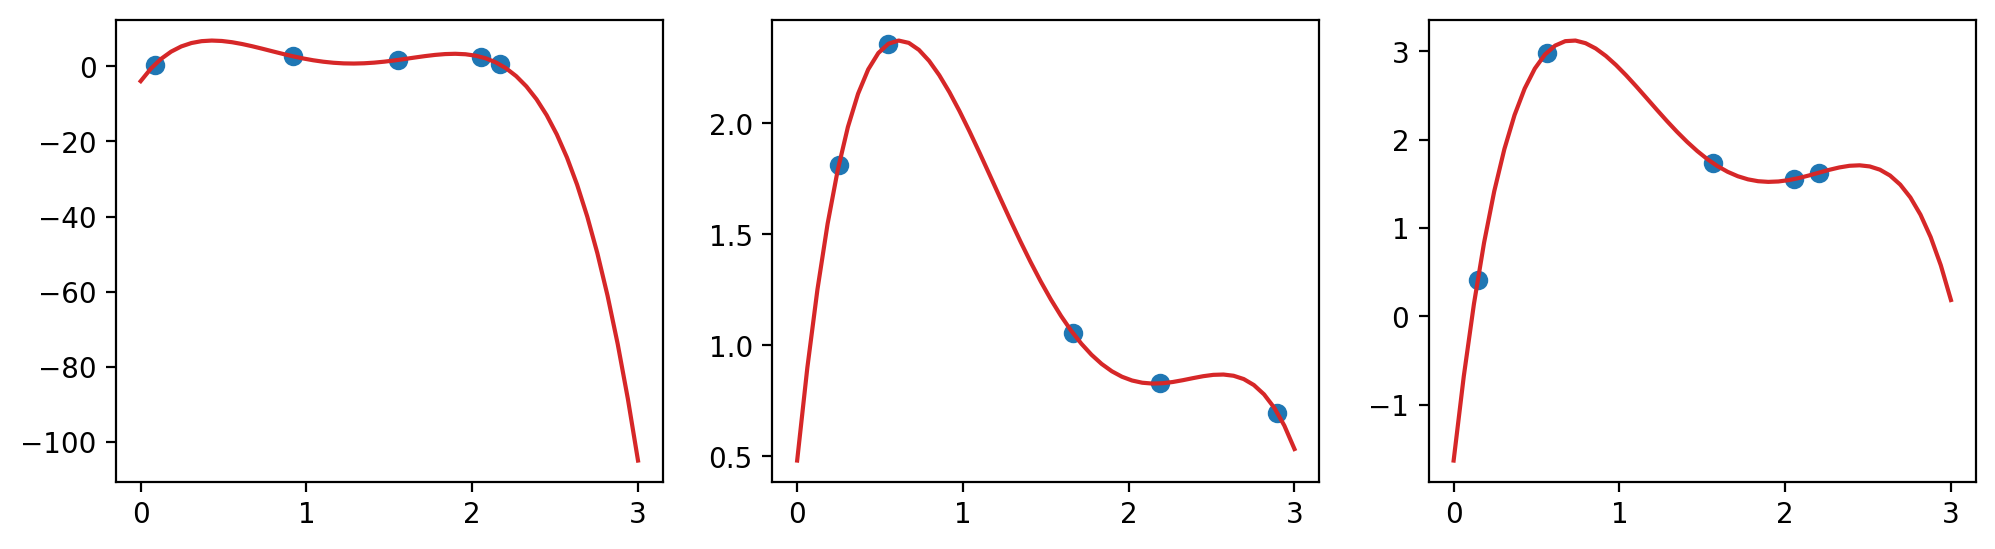

In [ ]:
np.random.seed(101)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for i in range(0, 3):
    points = 3*np.random.uniform(size=(5, 2))

    polynomial_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(4)),
                ('linear_regression', LinearRegression())
            ])

    polynomial_model.fit(points[:, [0]], points[:, 1])

    ax[i].scatter(points[:, 0], points[:, 1])

    xs = np.linspace(0, 3)
    ax[i].plot(xs, polynomial_model.predict(xs[:, np.newaxis]), c="tab:red");

You may be tempted to always design models with high polynomial degree – after all, we know that we could theoretically achieve perfect predictions by creating a model with enough polynomial features.

It turns out that the examples we looked at above represent a somewhat artificial scenario: we trained our model on all the data we had available, then used the model to make predictions on this very same dataset. A more realistic situation is when we wish to apply our model on unseen data – that is, datapoints that it did not encounter during the model fitting process.

Suppose we obtain a random sample of 6 datapoints from our population of vehicle data. We want to train a model on these 6 points and use it to make predictions on unseen data (perhaps cars for which we don't already know the true `mpg`).

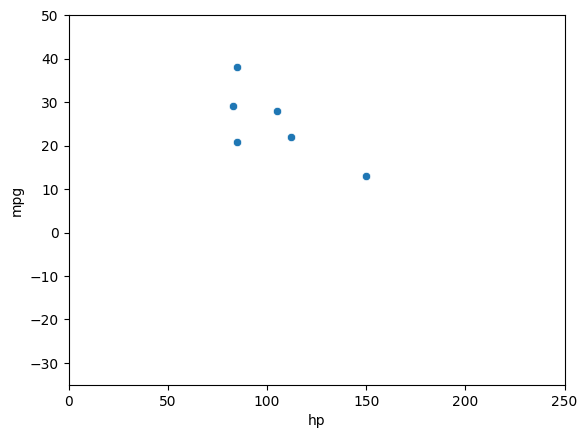

In [ ]:
np.random.seed(100)

sample_6 = vehicles.sample(6)

sns.scatterplot(data=sample_6, x="hp", y="mpg")
plt.ylim(-35, 50)
plt.xlim(0, 250);

If we design a model with polynomial degree 5, we can make perfect predictions on this sample of training data.

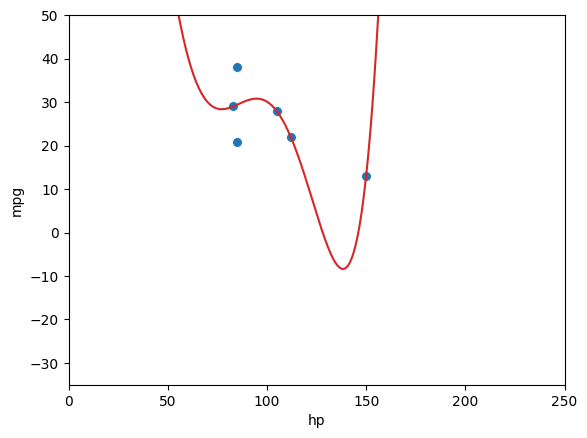

In [ ]:
degree_5_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(5)),
                ('linear_regression', LinearRegression())
            ])

degree_5_model.fit(sample_6[["hp"]], sample_6["mpg"])
xs = np.linspace(0, 250, 1000)
degree_5_model_predictions = degree_5_model.predict(xs[:, np.newaxis])

plt.plot(xs, degree_5_model_predictions, c="tab:red")
sns.scatterplot(data=sample_6, x="hp", y="mpg", s=50)
plt.ylim(-35, 50)
plt.xlim(0, 250);

However, when we reapply this fitted model to the full population of data, it fails to capture the major trends of the dataset.

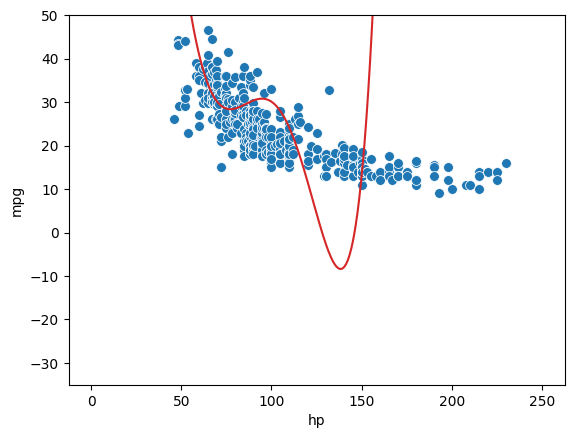

In [ ]:
plt.plot(xs, degree_5_model_predictions, c="tab:red")
sns.scatterplot(data=vehicles, x="hp", y="mpg", s=50)
plt.ylim(-35, 50);

The model has **overfit** to the data used to train it. It has essentially "memorized" the six datapoints used during model fitting, and does not generalize well to new data.

Complex models tend to be more sensitive to the data used to train them. The **variance** of a model refers to its tendency to vary depending on the training data used during model fitting. It turns out that our degree-5 model has very high model variance. If we randomly sample new sets of datapoints to use in training, the model varies erratically.

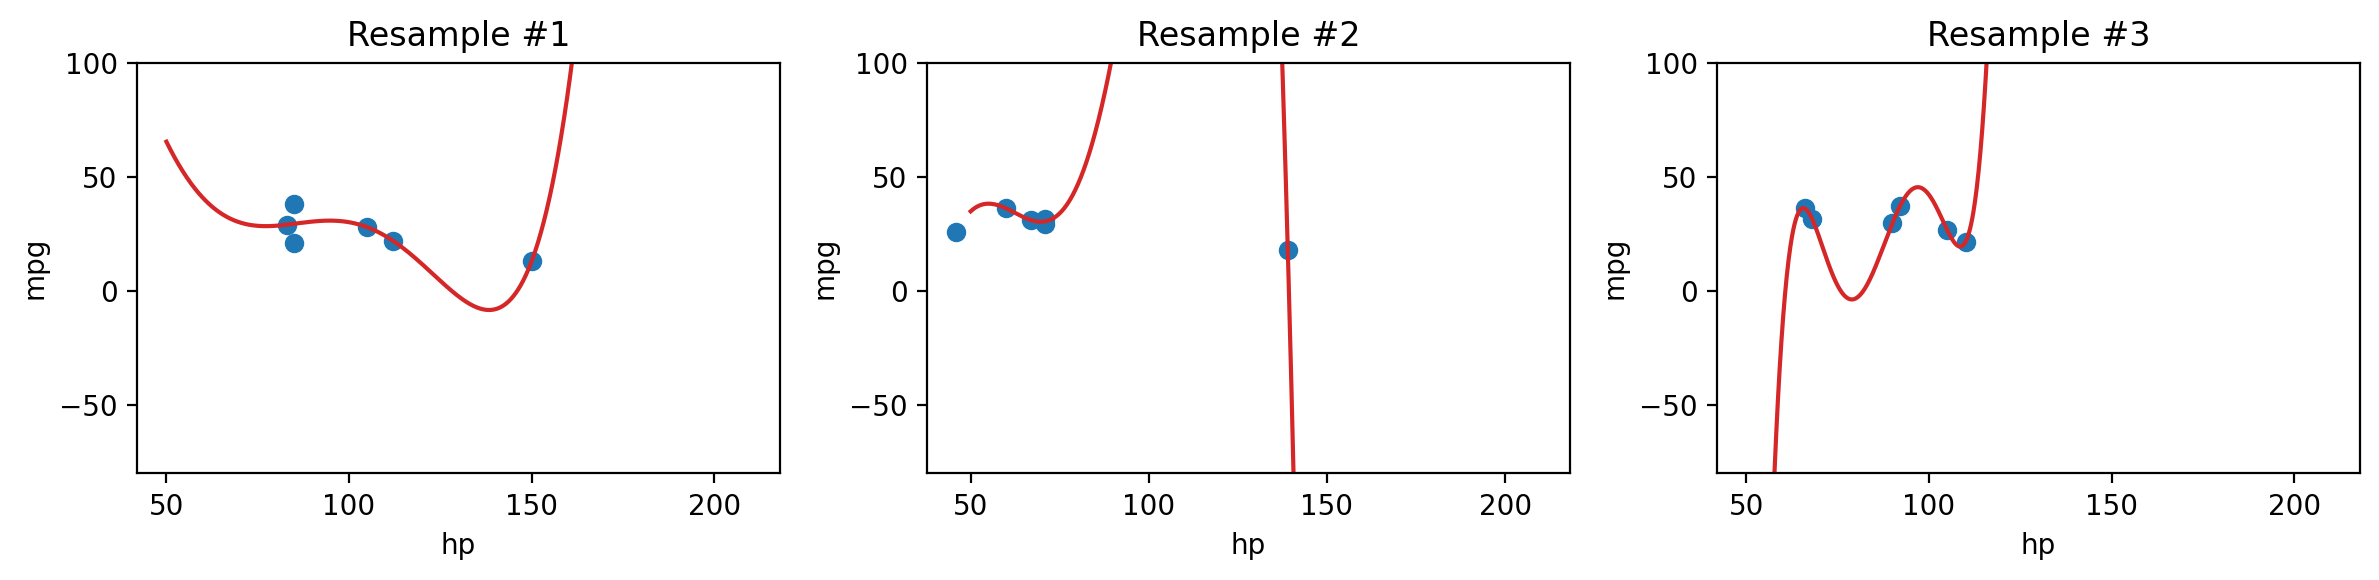

In [ ]:
np.random.seed(100)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for i in range(0, 3):
    sample = vehicles.sample(6)

    polynomial_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(5)),
                ('linear_regression', LinearRegression())
            ])

    polynomial_model.fit(sample[["hp"]], sample["mpg"])

    ax[i].scatter(sample[["hp"]], sample["mpg"])

    xs = np.linspace(50, 210, 1000)
    ax[i].plot(xs, polynomial_model.predict(xs[:, np.newaxis]), c="tab:red")
    ax[i].set_ylim(-80, 100)
    ax[i].set_xlabel("hp")
    ax[i].set_ylabel("mpg")
    ax[i].set_title(f"Resample #{i+1}")

fig.tight_layout();

Visualizing differently:

In [ ]:
np.random.seed(16)

fig = px.scatter(vehicles, x="hp", y="mpg", width=800, height=600)

for i in range(0, 3):
    sample = vehicles.sample(6).sort_values("hp")

    polynomial_model = Pipeline([
                ('polynomial_transformation', PolynomialFeatures(5)),
                ('linear_regression', LinearRegression())
            ])

    polynomial_model.fit(sample[["hp"]], sample["mpg"])

    name = f"Sample {i+1}"
    fig.add_trace(go.Scatter(x=sample["hp"], y=sample["mpg"],
        name=name, legendgroup=name, mode="markers", showlegend=False,
        marker_size=16,
        marker_color=px.colors.qualitative.Plotly[i+1]))
    xs = np.linspace(10, 250, 1000)
    fig.add_trace(go.Scatter(x=xs,
        y=polynomial_model.predict(xs[:, np.newaxis]),
        name=name, legendgroup=name, mode="lines",
        line_color=px.colors.qualitative.Plotly[i+1]))

fig.update_yaxes(range=[0, 50])